<>:190: SyntaxWarning: invalid escape sequence '\m'
<>:190: SyntaxWarning: invalid escape sequence '\m'
/var/folders/n7/h8vtfbcn3cn8b86gk1fgql700000gn/T/ipykernel_41721/907659915.py:190: SyntaxWarning: invalid escape sequence '\m'
  fig_scatter.text(0.04, 0.5, 'MWC ($\mathrm{mg\;g^{-1}}$)', # Use mathrm for non-italic text, \; for small space


成功加载字体属性从: /Users/annfengdeye/Library/Fonts/SimHei.ttf
已设置 axes.unicode_minus = False

成功从 'ckhnva.csv' 读取数据。
正在转换数值列...
数据清洗：原始行数 153, 清理后(NaN)有效行数 89 (删除了 64 行在关键列含NaN值的记录)

--- 正在生成散点图 ---
为子图 (a) - 'latitude' 添加了趋势线。
散点图已保存为: scatter_plots_MWC_relationships_logY_largefont_noborder_trendline_a.png


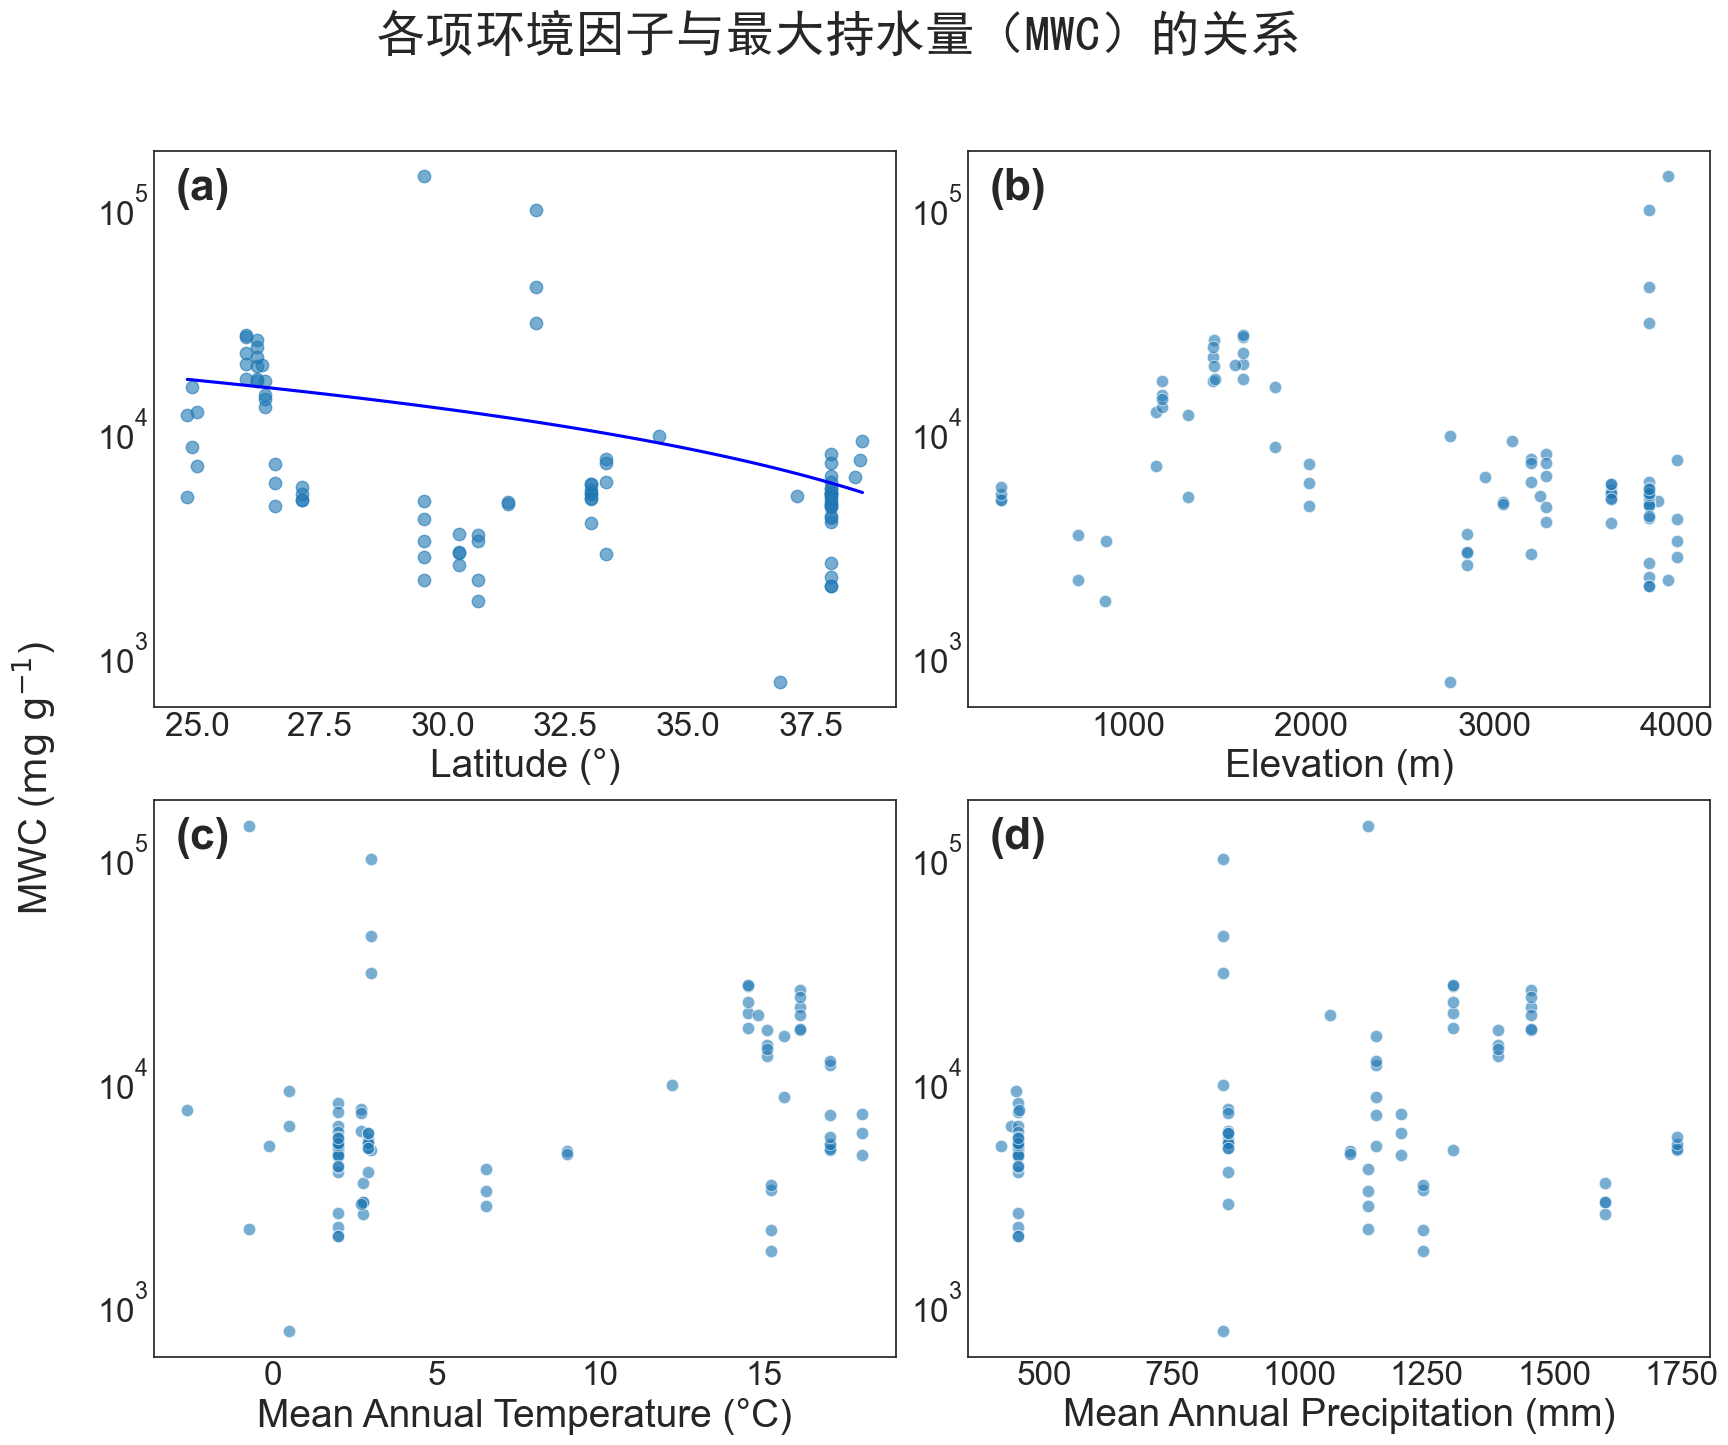


--- 正在生成地图 ---
GeoDataFrame创建成功。
加载世界地图数据集时出错: No matching item found for the query 'naturalearth_lowres'.. 将不使用底图。
无底图，直接绘制样点。
地图已保存为: study_locations_map_largefont_noborder.png


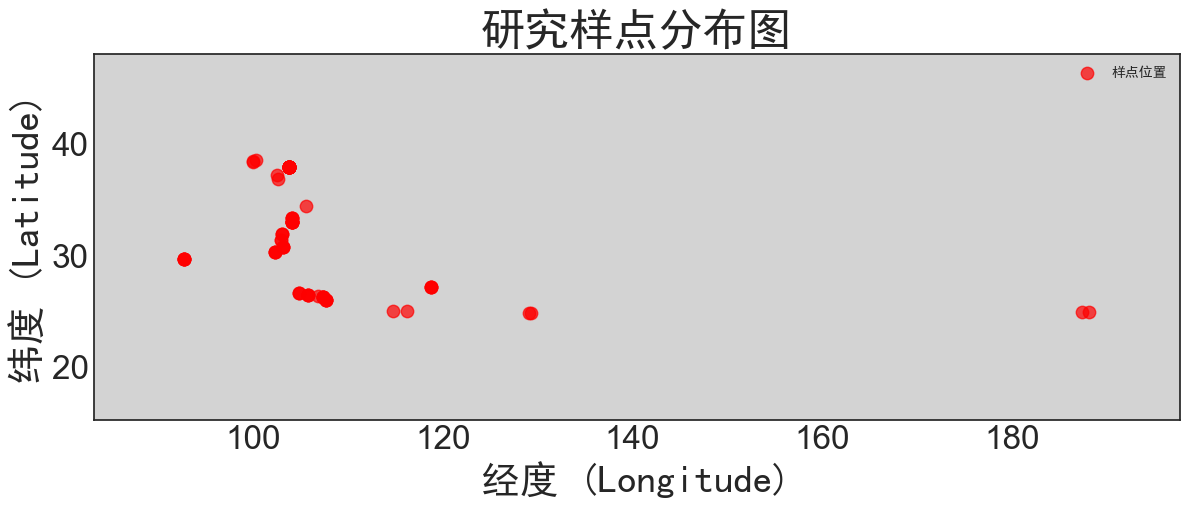


分析完成。


In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # <-- Import font_manager
import seaborn as sns
import geopandas
import numpy as np
import geodatasets
import platform
import os # <-- Import os to check path
import time # <-- Import time for timestamped filenames (optional)

# --- 请将下面的路径替换为你系统上实际存在的字体文件路径 ---
# 示例:
# windows_path = r"C:\Windows\Fonts\simhei.ttf" # 使用原始字符串或双反斜杠
macos_path = "/Users/annfengdeye/Library/Fonts/SimHei.ttf" # PingFang SC (可能需要指定字体索引,见下)
# linux_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.otf"

# --- 在这里输入你的路径 ---
# 使用你提供的 macOS 路径作为示例
chinese_font_path = "/Users/annfengdeye/Library/Fonts/SimHei.ttf"
# --- 修改结束 ---

# 检查字体路径是否有效
font_prop = None
if os.path.exists(chinese_font_path):
    try:
        font_prop = fm.FontProperties(fname=chinese_font_path)
        print(f"成功加载字体属性从: {chinese_font_path}")
        # 设置 Matplotlib 支持中文显示（如果需要）
        # plt.rcParams['font.family'] = font_prop.get_name() # 全局设置，有时不一定需要
        plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题
        print("已设置 axes.unicode_minus = False")
    except Exception as e:
        print(f"错误：无法从路径 '{chinese_font_path}' 加载字体属性: {e}")
        font_prop = None
else:
    print(f"错误：指定的字体文件路径不存在: '{chinese_font_path}'")

if font_prop is None:
    print("\n警告：未能加载指定的字体文件。后续图表中的中文（如图例、标题等）将可能无法正确显示！")

# --- 从CSV文件读取数据 ---
try:
    csv_file_path = 'ckhnva.csv'
    df = pd.read_csv(csv_file_path)
    print(f"\n成功从 '{csv_file_path}' 读取数据。")
except FileNotFoundError:
    print(f"错误：找不到文件 '{csv_file_path}'。请确保文件存在于正确的位置。")
    exit()
except Exception as e:
    print(f"读取CSV文件时发生错误: {e}")
    exit()

# --- 数据清洗与准备 ---
numeric_cols = ['latitude', 'elevation', 'MAT', 'MAP', 'MWC', 'longitude']
print("正在转换数值列...")
missing_cols = []
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # --- 新增：检查 MWC 是否有非正数，因为对数轴需要正数 ---
        if col == 'MWC':
              non_positive_mwc = df[df[col] <= 0][col].count()
              if non_positive_mwc > 0:
                    print(f"警告：列 'MWC' 包含 {non_positive_mwc} 个非正值。这些值将在对数刻度图中被忽略或导致错误。")
                    # 可选：移除或替换非正值
                    # df = df[df[col] > 0]
                    # print(f"已移除 'MWC' 列中的非正值记录。")
    else:
        print(f"警告：数据文件中缺少列 '{col}'")
        missing_cols.append(col)
numeric_cols = [col for col in numeric_cols if col not in missing_cols]
# 确保绘图所需的所有列都存在
plot_cols = [col for col in ['latitude', 'elevation', 'MAT', 'MAP', 'MWC'] if col in df.columns]


if 'MWC' not in df.columns:
     print("错误：数据文件中缺少 'MWC' 列，无法绘制散点图。")
     exit()

initial_rows = len(df)
# 清理时基于实际存在的绘图列
existing_plot_cols_for_dropna = [col for col in plot_cols if col in df.columns]
if not existing_plot_cols_for_dropna:
    print("错误：数据文件中缺少所有用于绘图的关键数值列。无法继续。")
    exit()

# 增加对 MWC > 0 的过滤，因为要用对数轴
df_cleaned = df.dropna(subset=existing_plot_cols_for_dropna)
original_cleaned_rows = len(df_cleaned)
df_cleaned = df_cleaned[df_cleaned['MWC'] > 0]
log_filtered_rows = original_cleaned_rows - len(df_cleaned)

cleaned_rows = len(df_cleaned)
print(f"数据清洗：原始行数 {initial_rows}, 清理后(NaN)有效行数 {original_cleaned_rows} (删除了 {initial_rows - original_cleaned_rows} 行在关键列含NaN值的记录)")
if log_filtered_rows > 0:
    print(f"对数轴过滤：进一步删除了 {log_filtered_rows} 行 MWC <= 0 的记录。最终用于绘图的行数: {cleaned_rows}")


# --- 散点图 ---
if cleaned_rows > 0:
    print("\n--- 正在生成散点图 ---")
    plt.style.use('seaborn-v0_8-white') # 使用无网格样式

    # --- 修改：字体大小加倍 ---
    base_fontsize = 24
    label_fontsize = 28
    title_fontsize = 32
    suptilte_fontsize = 36

    # --- 修改：增大图形尺寸以容纳大字体 ---
    fig_scatter, axes = plt.subplots(2, 2, figsize=(18, 16))

    # 应用字体到总标题
    fig_scatter.suptitle('各项环境因子与最大持水量（MWC）的关系', fontsize=suptilte_fontsize, fontproperties=font_prop if font_prop else None) # 应用字体

    x_vars_available = []
    for var in ['latitude', 'elevation', 'MAT', 'MAP']:
        if var in df_cleaned.columns:
            x_vars_available.append(var)
        else:
              print(f"警告：数据文件中缺少用于绘图的列 '{var}'")

    x_labels_map = {
        'latitude': 'Latitude (°)',
        'elevation': 'Elevation (m)',
        'MAT': 'Mean Annual Temperature (°C)',
        'MAP': 'Mean Annual Precipitation (mm)'
    }
    subplot_labels = ['(a)', '(b)', '(c)', '(d)']

    axes = axes.flatten()
    plot_index = 0
    for var in x_vars_available:
        ax = axes[plot_index]

        ax.grid(False) # 确保无网格
        for spine in ax.spines.values(): # 确保有边框
            spine.set_visible(True)

        if not df_cleaned[var].isnull().all() and not df_cleaned['MWC'].isnull().all():
            try:
                # <-- CHANGE: Add trendline only for the first plot (index 0) -->
                if plot_index == 0:
                    sns.regplot(data=df_cleaned, x=var, y='MWC', ax=ax,
                                scatter_kws={'alpha':0.6, 's':80}, # Keep scatter style
                                line_kws={'color':'blue'},        # Style trendline (optional)
                                ci=None)                           # No confidence interval
                    print(f"为子图 (a) - '{var}' 添加了趋势线。")
                else:
                    sns.scatterplot(data=df_cleaned, x=var, y='MWC', ax=ax, alpha=0.6, s=80)

                ax.set_yscale('log') # Apply log scale AFTER plotting

                # --- 修改：应用加倍后的字体大小 ---
                ax.set_xlabel(x_labels_map.get(var, var), fontsize=label_fontsize)
                # <-- CHANGE: Remove individual y-axis labels -->
                ax.set_ylabel('') # Set Y label to empty for individual plots

                ax.text(0.03, 0.97, subplot_labels[plot_index], transform=ax.transAxes,
                         fontsize=title_fontsize, fontweight='bold', va='top', ha='left')
                ax.tick_params(axis='both', which='major', labelsize=base_fontsize)

                plot_index += 1
            except Exception as e:
                  print(f"绘制 {x_labels_map.get(var, var)} vs MWC 时出错: {e}")
                  ax.set_title(f'{x_labels_map.get(var, var)}\n（绘图出错）', fontproperties=font_prop if font_prop else None, fontsize=label_fontsize)
                  ax.set_ylabel('') # Also remove label on error
                  ax.text(0.03, 0.97, subplot_labels[plot_index], transform=ax.transAxes,
                           fontsize=title_fontsize, fontweight='bold', va='top', ha='left')
                  ax.tick_params(axis='both', which='major', labelsize=base_fontsize) # 应用字体大小
                  plot_index += 1
        else:
            ax.text(0.5, 0.5, '无足够有效数据', transform=ax.transAxes,
                    fontsize=label_fontsize, fontweight='normal', va='center', ha='center',
                    fontproperties=font_prop if font_prop else None)
            ax.set_ylabel('') # Also remove label here
            ax.text(0.03, 0.97, subplot_labels[plot_index], transform=ax.transAxes,
                    fontsize=title_fontsize, fontweight='bold', va='top', ha='left')
            if var in df_cleaned.columns: ax.set_xlabel(x_labels_map.get(var, var), fontsize=label_fontsize)
            ax.tick_params(axis='both', which='major', labelsize=base_fontsize)
            plot_index += 1

    # 隐藏未使用的子图
    for i in range(plot_index, len(axes)):
        axes[i].set_visible(False)

    # --- CHANGE: Modify shared Y-axis label text ---
    fig_scatter.text(0.04, 0.5, 'MWC ($\mathrm{mg\;g^{-1}}$)', # Use mathrm for non-italic text, \; for small space
                     va='center', rotation='vertical', fontsize=label_fontsize)

    # --- 修改：调整布局，为更大的字体和标签提供更多空间 ---
    plt.tight_layout(rect=[0.08, 0.08, 1, 0.94]) # Adjust rect slightly if needed for new label spacing

    # --- 保存散点图 ---
    # Update filename to reflect trendline addition
    scatter_filename = 'scatter_plots_MWC_relationships_logY_largefont_noborder_trendline_a.png'
    try:
        fig_scatter.savefig(scatter_filename, dpi=300, bbox_inches='tight')
        print(f"散点图已保存为: {scatter_filename}")
    except Exception as e:
        print(f"保存散点图 '{scatter_filename}' 时出错: {e}")

    plt.show() # 显示图形
else:
    print("数据清洗后无足够数据用于绘制散点图 (特别是 MWC > 0 的数据)。")


# --- 地图生成 (No changes needed here based on request) ---
df_for_map_check = df.dropna(subset=['longitude', 'latitude'])

if not df_for_map_check.empty and 'longitude' in df_for_map_check.columns and 'latitude' in df_for_map_check.columns:
    print("\n--- 正在生成地图 ---")
    if df_cleaned.empty:
         print("警告：虽然原始数据中有经纬度，但过滤掉NaN和MWC<=0后没有数据点可绘制在地图上。")
    else:
        df_map_ready = df_cleaned.dropna(subset=['longitude', 'latitude'])
        if df_map_ready.empty:
             print("无法生成地图：过滤后的数据中未找到有效的经纬度坐标对。")
        else:
             gdf = None
             try:
                 gdf = geopandas.GeoDataFrame(
                     df_map_ready,
                     geometry=geopandas.points_from_xy(df_map_ready.longitude, df_map_ready.latitude)
                 )
                 gdf.set_crs(epsg=4326, inplace=True)
                 print("GeoDataFrame创建成功。")
             except Exception as e:
                   print(f"创建GeoDataFrame时出错: {e}")

             if gdf is not None:
                 world = None
                 try:
                     path_to_world = geodatasets.get_path('naturalearth_lowres')
                     world = geopandas.read_file(path_to_world)
                     print("成功加载世界底图。")
                 except Exception as e:
                     print(f"加载世界地图数据集时出错: {e}. 将不使用底图。")

                 fig_map, ax = plt.subplots(1, 1, figsize=(12, 10))
                 ax.grid(False)
                 for spine in ax.spines.values():
                     spine.set_visible(True)

                 if world is not None:
                     world.plot(ax=ax, color='lightgrey', edgecolor='black')
                 else:
                     ax.set_facecolor('lightgrey')
                     print("无底图，直接绘制样点。")

                 gdf.plot(ax=ax, marker='o', color='red', markersize=80, label='样点位置', alpha=0.7)

                 try:
                     minx, miny, maxx, maxy = gdf.total_bounds
                     padding_ratio = 0.1
                     x_pad = (maxx - minx) * padding_ratio if maxx > minx else 1
                     y_pad = (maxy - miny) * padding_ratio if maxy > miny else 1
                     padding = max(x_pad, y_pad, 2)
                     ax.set_xlim(minx - padding, maxx + padding)
                     ax.set_ylim(miny - padding, maxy + padding)
                 except Exception as e:
                     print(f"设置地图边界时出错: {e}. 使用默认边界。")

                 ax.set_title('研究样点分布图', fontproperties=font_prop if font_prop else None, fontsize=title_fontsize)
                 ax.set_xlabel('经度 (Longitude)', fontproperties=font_prop if font_prop else None, fontsize=label_fontsize)
                 ax.set_ylabel('纬度 (Latitude)', fontproperties=font_prop if font_prop else None, fontsize=label_fontsize)
                 ax.tick_params(axis='both', which='major', labelsize=base_fontsize)

                 try:
                     legend = ax.legend(prop=font_prop if font_prop else None, fontsize=base_fontsize)
                 except AttributeError:
                     print("地图上没有图例可设置字体。")

                 plt.tight_layout()

                 map_filename = 'study_locations_map_largefont_noborder.png' # Filename remains same
                 try:
                     fig_map.savefig(map_filename, dpi=300, bbox_inches='tight')
                     print(f"地图已保存为: {map_filename}")
                 except Exception as e:
                     print(f"保存地图 '{map_filename}' 时出错: {e}")

                 plt.show() # 显示图形
else:
    if 'longitude' not in df.columns or 'latitude' not in df.columns:
        print("\n无法生成地图：数据文件中缺少'longitude'或'latitude'列。")
    elif df_for_map_check.empty:
        print("\n无法生成地图：原始数据中清理NaN后未找到有效的经纬度坐标对。")
    else:
         print("\n无法生成地图：发生了未知错误。")


print("\n分析完成。")